# Keras
## BUDT737_Group_Project_06

## Import necessary libraries

In [1]:
# Importing the necessary libraries
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

## Loading the Dataset and EDA

In [2]:
# Loading the Dataset files 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Checking if there are null values in the training dataset
## https://sparkbyexamples.com/pandas/count-nan-values-in-pandas/
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
# Checking if the two classes in the training dataset are balanced
## https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html#pandas.DataFrame.value_counts
count_target = pd.DataFrame(train['target'].value_counts()) #Return a Series containing counts of unique rows in the DataFrame
count_target.reset_index()

,index,target
0,0,4342
1,1,3271


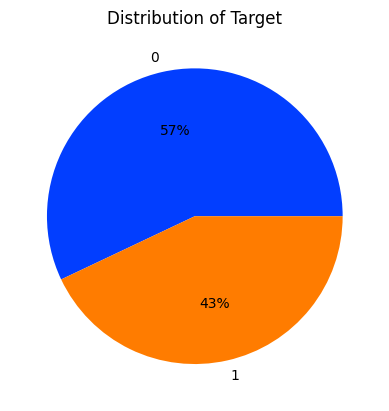

In [7]:
# Plotting the distribution of target by pie chart
## https://www.geeksforgeeks.org/how-to-create-a-pie-chart-in-seaborn/
import matplotlib.pyplot as plt
import seaborn
# define Seaborn color palette to use
palette_color = seaborn.color_palette('bright')
plt.pie(count_target.target, labels=count_target.index, colors=palette_color, autopct='%.0f%%')
plt.title('Distribution of Target')
plt.show()

In [8]:
# Count the length of text by str.len()
## https://www.geeksforgeeks.org/python-pandas-series-str-len/
train['text length']= train['text'].str.len() #A method used to determine length of each string in a Pandas series
train.head()

,id,keyword,location,text,target,text length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


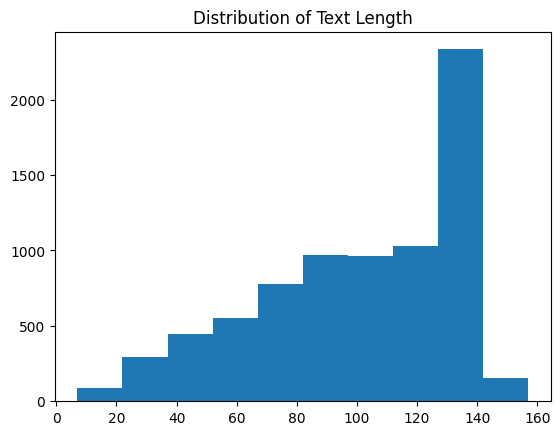

In [9]:
# Plotting the distribution of text length by histogram
## https://matplotlib.org/
plt.hist(train['text length'])
plt.title('Distribution of Text Length')
plt.show()

## Cleaning the text

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string

## https://docs.python.org/3/
## https://www.crummy.com/software/BeautifulSoup/bs4/doc/
## https://www.nltk.org/

nltk.download('stopwords') # Downloading the stopwords corpus from NLTK
nltk.download('wordnet') # Downloading the WordNet corpus from NLTK

# Forming an example of the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# removing HTML tags from text
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Cleaning the text 
def clean_text(text):
    text = text.lower()  # convert text to lower case
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove @usernames or #hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = remove_html(text)  # remove any HTML tags
    text = text.encode('ascii', 'ignore').decode('ascii')  # remove emojis
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]  # lemmatization
    text = [word for word in text if not word in stopwords.words()]  # remove stopwords
    text = " ".join(text)  # join the words back into a string
    return text

# Cleaning the text in the 'text' column of the 'train' DataFrame
train['text'] = train['text'].apply(clean_text)

# Clean the text in the 'text' column of the 'test' DataFrame
test['text'] = test['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Initialize Tokenizer

In [11]:
# Tokenizer Fit on the text data
## https://keras.io/
## https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])

train_sequences = tokenizer.texts_to_sequences(train['text'])
test_sequences = tokenizer.texts_to_sequences(test['text'])
max_seq_length = max([len(x) for x in train_sequences]) # maximum sequence length among the training sequences
train_sequences = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post') # padding the sequences to have a consistent length 
test_sequences = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

## Build the model

In [12]:
# Creating and Training a Keras Model 
seed = 123 #Set the random seed
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_seq_length))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_sequences, train['target'], epochs=10, validation_split=0.33)

Epoch 1/10
160/160 [==============================] - 24s 95ms/step - loss: 0.5632 - accuracy: 0.7065 - val_loss: 0.5027 - val_accuracy: 0.7593
Epoch 2/10
160/160 [==============================] - 6s 37ms/step - loss: 0.3063 - accuracy: 0.8875 - val_loss: 0.5197 - val_accuracy: 0.7429
Epoch 3/10
160/160 [==============================] - 3s 20ms/step - loss: 0.1821 - accuracy: 0.9414 - val_loss: 0.7113 - val_accuracy: 0.7151
Epoch 4/10
160/160 [==============================] - 3s 18ms/step - loss: 0.1369 - accuracy: 0.9588 - val_loss: 0.9387 - val_accuracy: 0.6956
Epoch 5/10
160/160 [==============================] - 2s 14ms/step - loss: 0.1164 - accuracy: 0.9645 - val_loss: 0.6683 - val_accuracy: 0.7147
Epoch 6/10
160/160 [==============================] - 3s 17ms/step - loss: 0.0916 - accuracy: 0.9710 - val_loss: 0.8162 - val_accuracy: 0.7203
Epoch 7/10
160/160 [==============================] - 2s 15ms/step - loss: 0.0751 - accuracy: 0.9702 - val_loss: 1.2184 - val_accuracy: 0.703

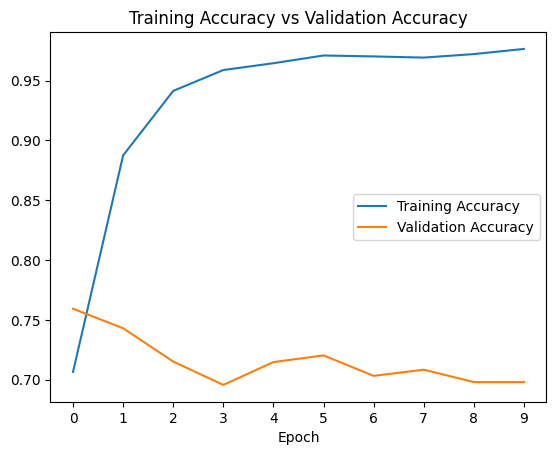

In [14]:
# Plotting a visualization for Training vs Validation Accuracy
## https://www.geeksforgeeks.org/how-to-adjust-number-of-ticks-in-seaborn-plots/
import seaborn as sns
sns.lineplot(history.history['accuracy'], label='Training Accuracy')
lplot = sns.lineplot(history.history['val_accuracy'], label='Validation Accuracy')
lplot.set_title('Training Accuracy vs Validation Accuracy')
lplot.set_xlabel('Epoch')
lplot.set_xticks(range(10))

## Accuracy

In [15]:
#Final Training and Validation Accuracy 
print("Train Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Train Accuracy:  0.9764705896377563
Validation Accuracy:  0.6979705691337585


## Model 2 with better Accuracy

In [16]:
# Importing the necessary libraries for Model 2
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
import keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

##Using pre-trained word embeddings
Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/

Created a vocabulary index

In [17]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train['text']).batch(128)
vectorizer.adapt(text_ds)
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [18]:
#vectorizing a test sentence:
len(vectorizer.get_vocabulary())
output = vectorizer([["the cat sat on the mat"]])
output.numpy()
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/

array([[ 769,    1, 2403, 4365,  769,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [19]:
#dict mapping words to their indices and checking the length on voc
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
len(voc)
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/

13782

Loading pre-trained word embeddings

In [20]:
#downloaded pre-trained GloVe embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/

--2023-05-17 01:27:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-17 01:27:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-17 01:27:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
#making a dict mapping words (strings) to their NumPy vector representation and we have used the 300D ones.
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/
path_to_glove_file =  "glove.6B.300d.txt"


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepared embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

#loaded the pre-trained word embeddings matrix into an Embedding layer
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Found 400000 word vectors.
Converted 10617 words (3165 misses)


##KERAS MODEL

In [22]:
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/
from tensorflow.keras import layers
seed = 123 #Set the random seed
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="tanh")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="tanh")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(int_sequences_input, preds)

In [23]:
#trained the model2
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/
x_train = vectorizer(np.array([[s] for s in train['text']])).numpy()
y_train = np.array(train['target'])

In [24]:
#Citation: https://keras.io/examples/nlp/pretrained_word_embeddings/
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=128, epochs=5,validation_split=0.2)

Epoch 1/5
48/48 [==============================] - 9s 26ms/step - loss: 0.6723 - accuracy: 0.5977 - val_loss: 0.6404 - val_accuracy: 0.6855
Epoch 2/5
48/48 [==============================] - 1s 12ms/step - loss: 0.5690 - accuracy: 0.7470 - val_loss: 0.4951 - val_accuracy: 0.7768
Epoch 3/5
48/48 [==============================] - 1s 13ms/step - loss: 0.4654 - accuracy: 0.7966 - val_loss: 0.4570 - val_accuracy: 0.7978
Epoch 4/5
48/48 [==============================] - 1s 12ms/step - loss: 0.4112 - accuracy: 0.8256 - val_loss: 0.4492 - val_accuracy: 0.8017
Epoch 5/5
48/48 [==============================] - 1s 12ms/step - loss: 0.3728 - accuracy: 0.8494 - val_loss: 0.4500 - val_accuracy: 0.8024


## Results and Visualization

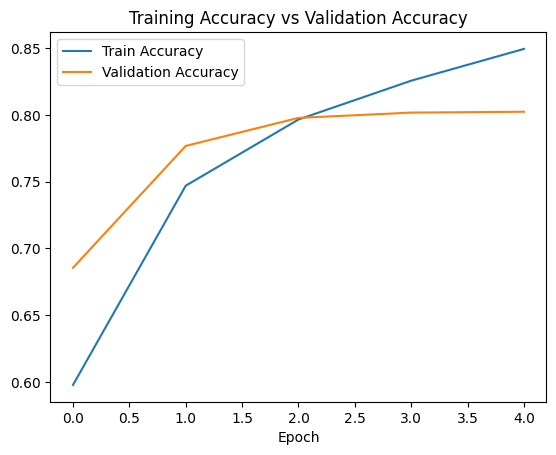

In [25]:
#Training Accuracy vs Validation Accuracy Visualization
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

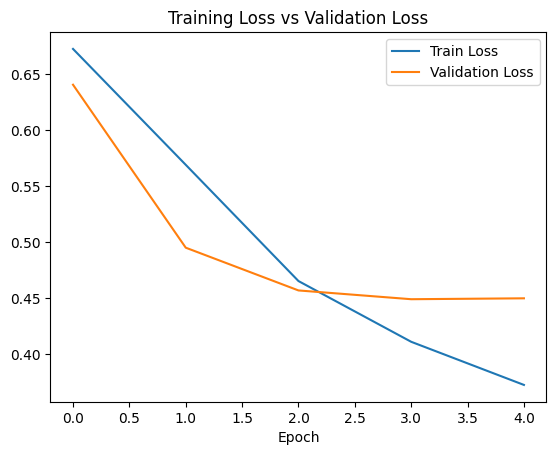

In [26]:
#Train Loss vs Validation Loss Visualization
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Accuracy

In [27]:
print("Train Accuracy: ", history2.history['accuracy'][-1])
print("Validation Accuracy: ", history2.history['val_accuracy'][-1])

Train Accuracy:  0.8494253158569336
Validation Accuracy:  0.8023637533187866


In [28]:
# Find the maximum accuracy achieved
max_accuracy = max(history2.history['val_accuracy'])
print("Maximum accuracy is :", max_accuracy)

Maximum accuracy is : 0.8023637533187866


## Make predictions

In [29]:
# Making predictions on the test set 

#x_test = vectorizer(np.array([[s] for s in val_samples])).numpy()
#y_test = np.array(val_labels)

x_test = vectorizer(np.array([[s] for s in test['text']])).numpy()

In [30]:
test_preds = model2.predict(x_test)
test_preds = [1 if pred > 0.5 else 0 for pred in test_preds]

102/102 [==============================] - 1s 3ms/step


In [31]:
test_preds

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,


## Add predictions to sample_submission

In [32]:
# Assigning the predicted target values to the 'target' column of the 'sample_submission' DataFrame
sample_submission['target'] = test_preds
sample_submission.to_csv('submission.csv', index=False)